In [ ]:
import os
import sys




In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
from PIL import Image
import cv2
from samgeo import tms_to_geotiff
from src.utils.logger import default_logger as logger
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, Concatenate, GlobalAveragePooling2D




class Preprocessor:
    def __init__(self, data, scaler):
        self.data = data
        self.scaler = scaler
        self.gdf_data =None
        self.geom_buffer =None
        self.image =None
        self.X_transaction_scaled =None
    
    def gdf(self, data):
        """Preprocessing data for predition"""
        # try:
        data['geometry'] =data.apply(lambda x:Point(x['longitude'],x['latitude']),axis=1)
        self.gdf_data = gpd.GeoDataFrame(data, geometry='geometry', crs=4326)
        # except Exception as e:
        #     logger.error(f"failed to preprocess data")
        #     raise

    def buffer_area(self):
        """Buffering area of the geometry"""
        try:
            geom_buffer= self.gdf_data.to_crs(3393).buffer(1000, cap_style='square')
            self.geom_buffer = gpd.GeoDataFrame(geom_buffer,geometry =geom_buffer).to_crs(4326)
        except Exception as e:
            logger.error(f"failed to buffer area")
            raise
    
    def satelit_image(self):
        """Getting satellite image data"""
        try:
            # get satellite image data
            bbox =list(self.geom_buffer['geometry'][0] .bounds)
            random = np.random.rand(1,1000)
            #get image
            tiff_image_path = fr"D:\ML5\final_projectt\artifacts\data_prediction\image_{random}.tiff"
            tms_to_geotiff(output=tiff_image_path, bbox=bbox, zoom=17, source="Satellite", overwrite=True)
            self.png_image_path = fr"D:\ML5\final_projectt\artifacts\png\{random}.png"
            # Open the TIFF file using Pillow
            with Image.open(tiff_image_path) as img:
                # Save the image as PNG
                img.save(self.png_image_path, format="PNG")

        except Exception as e:
            logger.error(f"failed to get satellite image")
            raise
    # Function to load and preprocess images
    def load_images(self, img_size=(224, 224)):
        """Loading and preprocessing images"""
        try:
            # Ensure the image file exists
  
            img = cv2.imread(self.png_image_path)
            img = cv2.resize(img, img_size)
            img = img / 255.0  # Normalize
            self.img = np.array(img)

    
        except Exception as e:
            logger.error(f"failed to load image")
            raise
     
    def fit_transform(self):
        """Scaling data using minmaxscaler"""
        try:
            
            selected_features = ['bedroom', 'bathroom', 'building_area', 'land_area']
            X_transaction = self.gdf_data[selected_features].fillna(0).values
            self.X_transaction_scaled = self.scaler.fit_transform(X_transaction)
 
        except Exception as e:
            logger.error(f"failed to scale data")
            raise
        


    def extract_feature(self):
        """Extracting features from transaction data"""
        try:
            if self.gdf_data is None:
                self.gdf(self.data)
            if self.geom_buffer is None:
                self.buffer_area()
            if self.image is None:
                self.satelit_image()
                self.load_images()
            if self.X_transaction_scaled is None:
                self.fit_transform()
            
            X_img= np.expand_dims(self.img, axis=0)  # Shape becomes (1, 224, 224, 3)
            X_tx = np.expand_dims(self.X_transaction_scaled, axis=0) 

            display(X_img)
            display(X_tx)

            return X_img,X_tx
        except Exception as e:
            logger.info(f"Failed Extract Feature: {e}")
            raise
    

            
            





In [59]:
from fastapi import FastAPI, HTTPException, Depends
from pydantic import BaseModel
import uvicorn
import pandas as pd
import sys
import os
# Get the current working directory (Jupyter Notebook doesn't support __file__)
# BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))

# # Add BASE_DIR to sys.path if not already present
# if BASE_DIR not in sys.path:
#     sys.path.append(BASE_DIR)

# # Now, import modules from src
# from src.utils.logger import default_logger as logger
# from src.data.data_preprocessor import Preprocessor
# from src.data.data_loader import DataLoader



app = FastAPI(
    title="House Price Prediction API",
    description="API for predicting house prices based on several features.",
    version="1.0.0"
)

# Pydantic model for data validation
class HouseData(BaseModel):
    bedroom: int
    bathroom: int
    building_area: int
    land_area: int
    latitude: float
    longitude: float

# DataLoader instance
model_path = r"D:\ML5\final_projectt\artifacts\model\model.pkl"
scaler_path = r"D:\ML5\final_projectt\artifacts\model\scaler.pkl"
dl = DataLoader(model_path, scaler_path)

# Load model and scaler on startup

model = dl.load_model()
scaler = dl.load_scaler()

    #printjh
house_data ={"bedroom": 2,
  "bathroom": 1,
  "building_area": 58,
  "land_area": 50,
  "latitude": -7.3137835,
  "longitude": 112.6684179}


# Prepare data for prediction
data = dl.load_data_prediction(house_data)
data_processor = Preprocessor(data,scaler)


2025-02-12 20:35:45 | house_price | INFO | Initialized model with path: D:\ML5\final_projectt\artifacts\model\model.pkl
2025-02-12 20:35:45 | house_price | INFO | Initialized scaler with path: D:\ML5\final_projectt\artifacts\model\scaler.pkl
2025-02-12 20:35:46 | house_price | INFO | model load succesfully
2025-02-12 20:35:46 | house_price | INFO | Load scaller succes
2025-02-12 20:35:46 | house_price | INFO | Load data succes


In [74]:
x_img, x_tx= data_processor.extract_feature()

# Predict
try:
    prediction = model.predict([x_img,x_tx]) # Adjust indexing based on your model's output
    logger.info(f"Prediction successful: {prediction}")
 
except Exception as e:
    logger.error(f"Prediction failed: {e}")
    raise HTTPException(status_code=500, detail="Model prediction failed")


2025-02-12 20:41:44 | house_price | ERROR | Prediction failed: Unrecognized data type: x=[<PIL.TiffImagePlugin.TiffImageFile image mode=RGB size=984x991 at 0x1A89AE71360>, array([[0., 0., 0., 0.]])] (of type <class 'list'>)


HTTPException: 500: Model prediction failed

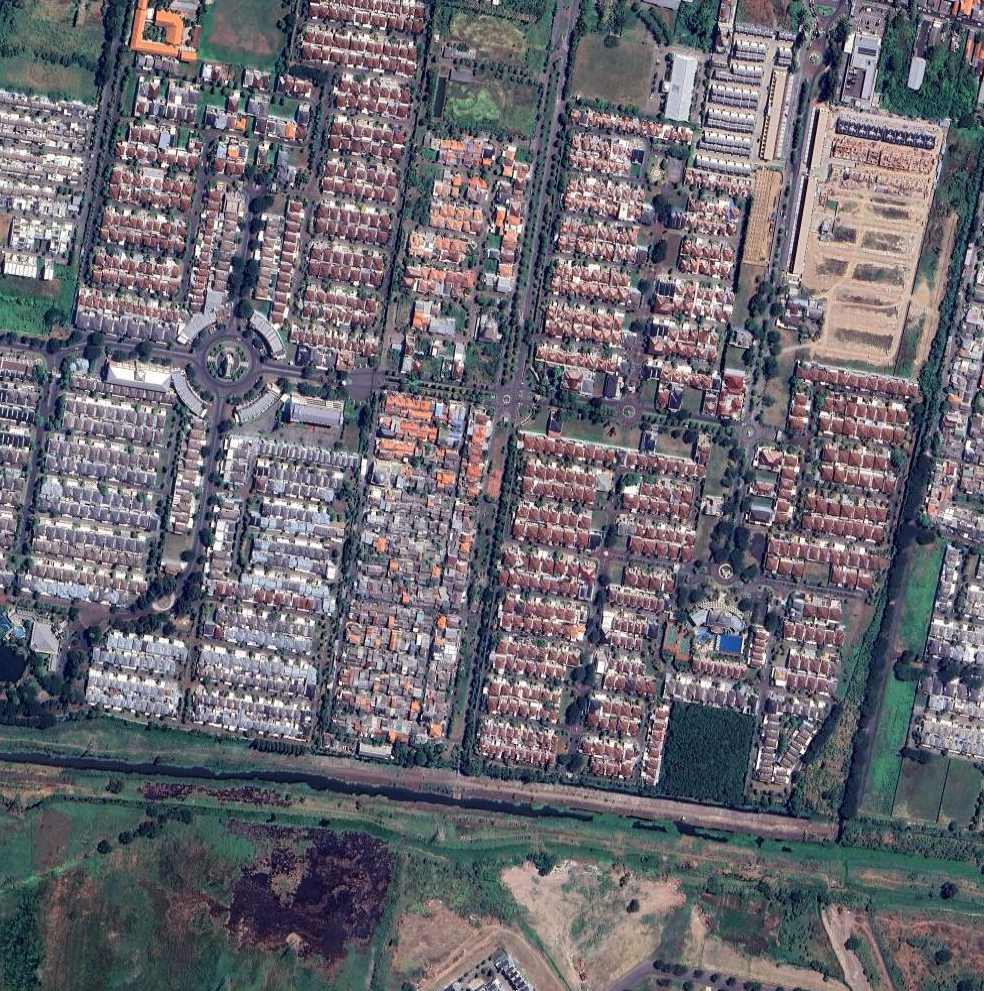

In [75]:
x_img

In [71]:
x_tx

array([[0., 0., 0., 0.]])

In [ ]:
try:
    prediction = model.predict(processed_data)[0][0]  # Adjust indexing based on your model's output
    logger.info(f"Prediction successful: {prediction}")
 
except Exception as e:
    logger.error(f"Prediction failed: {e}")
    raise HTTPException(status_code=500, detail="Model prediction failed")


In [41]:
processed_data[0][0]

<KerasTensor shape=(), dtype=float32, sparse=False, name=keras_tensor_4486>

In [26]:
data['geometry'] =data.apply(lambda x:Point(x['longitude'],x['latitude']),axis=1)
gdf_data = gpd.GeoDataFrame(data, geometry='geometry', crs=4326)

geom_buffer=gdf_data.to_crs(3393).buffer(1000, cap_style='square')
geom_buffer = gpd.GeoDataFrame(geom_buffer,geometry =geom_buffer).to_crs(4326)

In [22]:
geom_buffer

0    POLYGON ((9103724.691 -1690433.771, 9103724.69...
dtype: geometry

In [17]:
gdf_data.explore()